# <font color='blue'>Deep Learning II</font>

# Redes Neurais Recorrentes LSTM - Long Short-Term Memory 

Este Notebook está dividido nas seguintes etapas. Clique no título da etapa para acessá-la diretamente.

* [Etapa 1](#etapa1): Conjunto de dados
* [Etapa 2](#etapa2): Importar as Bibliotecas
* [Etapa 3](#etapa3): Criar o Modelo
* [Etapa 4](#etapa4): Testar o Modelo
* [Etapa 5](#etapa5): Realizar as Previsões

## Prevendo Séries Temporais com LSTMs

<a id = 'etapa1'></a>
## Etapa 1: Conjunto de dados

Previsão do número de óbitos de pacientes acima de 50 anos nas internações hospitalares - AIH.

Usaremos conjuntos de dados que mostram o número de óbitos de pacientes acima de 50 anos nas internações hospitalares - AIH. Os dados tem registros dos anos de 2010 a 2020.

Será fornecido 1 dataset com 2 colunas, data e número de Óbitos.

Usaremos conjuntos de dados que mostram o número de óbitos de pacientes acima de 50 anos nas internações hospitalares – AIH em Minas Gerais.

Os dados foram baixados do site do Datasus, módulo SIHSUS, tipo de arquivo RD- AIH Reduzida, anos de 2010 a 2020, UF MG, todos os meses:

http://www2.datasus.gov.br/DATASUS/index.php?area=0901&item=1&acao=25

Foi realizado o download de 129 arquivos, com 5.231.829 registros utilizados para preparar um arquivo csv com o agrupamento das internações das pessoas acima de 50 anos que vieram a óbito, perfazendo um total de 3.896 registros diários, 556 registros por semana (excluindo-se a primeira e a última), com data, número e valor total das internações, dados desde 2010.

<a id='etapa2'></a>
## Etapa 2: Importar as Bibliotecas

In [1]:
import tensorflow as tf
tf.__version__

'1.10.0'

In [2]:
import keras as k
k.__version__

Using TensorFlow backend.


'2.2.5'

In [3]:
# Imports
import math
import numpy
import pandas
import os
import io
import requests

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import load_model

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [4]:
# Converte array em matriz
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [5]:
# Define o PATH onde estão os dados
save_path = "./save"

# Random seed 
numpy.random.seed(7)

look_back = 1

Clique no título da etapa para acessá-la diretamente.

* [Etapa 3](#etapa3): Criar o Modelo
* [Etapa 4](#etapa4): Testar o Modelo
* [Etapa 5](#etapa5): Realizar as Previsões

<a id='etapa3'></a>
## Etapa 3: Criar o Modelo

In [7]:
# Carrega os dados
dataframediario = pandas.read_csv("./data/AIH.csv", usecols = [0, 1], engine = 'python')
dataframediario['Data'] = pandas.to_datetime(dataframediario.Data, format = '%d/%m/%Y')
dataframediario = dataframediario.set_index('Data')
# Reamostrando os dados para frequência semanal - Usando o valor médio do número de óbitos de pacientes – AIH
dataframesemanal = dataframediario['QT_INTER'].resample('W').sum()
dataframe = dataframesemanal.to_frame()
dataframe.drop(dataframe.head(1).index,inplace=True) # drop first 1 rows
dataframe.drop(dataframe.tail(1).index,inplace=True) # drop last 1 rows
dataframediario.reset_index(drop=True)

datasetfull = dataframe.values
datasetfull = datasetfull.astype('float32')


In [8]:
datasetfull.shape

(556, 1)

In [9]:
# Split em treino e teste
train_size = int(len(datasetfull) * 0.75)
test_size = len(datasetfull) - train_size
dataset, test = datasetfull[0:train_size,:], datasetfull[train_size:len(datasetfull),:]

In [10]:
# Normaliza os dados
# As LSTMs são sensíveis à escala dos dados de entrada, especificamente quando funções de ativação sigmoide (padrão)
# ou tanh são usadas. Pode ser uma boa prática redimensionar os dados para o range de 0 a 1, 
# também chamado de normalização. Podemos normalizar facilmente o conjunto de dados usando a classe MinMaxScaler do scikit-learn
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset)

In [11]:
# Split em treino e validação
train_size = int(len(dataset) * 0.67)
valid_size = len(dataset) - train_size
train, valid = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [12]:
dataset.shape

(417, 1)

In [13]:
train.shape

(279, 1)

In [14]:
valid.shape

(138, 1)

In [15]:
test.shape

(139, 1)

In [16]:
# Reshape em X=t e Y=t+1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)

# Reshape do input para: [samples, time steps, features]
# A rede LSTM espera que os dados de entrada (X) sejam fornecidos com uma estrutura de matriz específica 
# na forma de: [amostras, etapas de tempo, características]. Nossos dados preparados estão na forma: [amostras,
# features] e estamos enquadrando o problema como um único passo para cada amostra. Podemos transformar
# os dados de treino e de teste na estrutura esperada usando numpy.reshape() 
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = numpy.reshape(validX, (validX.shape[0], 1, validX.shape[1]))

In [17]:
# Cria o modelo LSTM
# Agora estamos prontos para projetar nossa rede LSTM para esse problema. A rede tem uma
# camada visível com 1 entrada, uma camada oculta com 4 blocos LSTM ou neurônios e uma camada de saída
# que faz uma previsão de valor único. A função de ativação sigmoid padrão é usada para
# os blocos de memória LSTM. A rede é treinada em 200 épocas e um tamanho de lote (batch_size) de 1 é usado.
model = Sequential()
model.add(LSTM(4, input_shape = (1, look_back)))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

# Early stoppping
monitor = EarlyStopping(monitor = 'val_loss', min_delta = 1e-3, patience = 5, verbose = 1, mode = 'auto')

model.fit(trainX, trainY, epochs = 200, batch_size = 1, verbose = 2)

#model.fit(trainX, trainY, validation_data = (validX, validY), callbacks = [monitor], verbose = 2, epochs = 200)


Epoch 1/200
 - 4s - loss: 0.0330
Epoch 2/200
 - 2s - loss: 0.0134
Epoch 3/200
 - 2s - loss: 0.0126
Epoch 4/200
 - 2s - loss: 0.0118
Epoch 5/200
 - 2s - loss: 0.0111
Epoch 6/200
 - 2s - loss: 0.0107
Epoch 7/200
 - 2s - loss: 0.0104
Epoch 8/200
 - 2s - loss: 0.0101
Epoch 9/200
 - 2s - loss: 0.0099
Epoch 10/200
 - 2s - loss: 0.0099
Epoch 11/200
 - 2s - loss: 0.0097
Epoch 12/200
 - 2s - loss: 0.0098
Epoch 13/200
 - 2s - loss: 0.0098
Epoch 14/200
 - 2s - loss: 0.0098
Epoch 15/200
 - 2s - loss: 0.0097
Epoch 16/200
 - 2s - loss: 0.0097
Epoch 17/200
 - 2s - loss: 0.0097
Epoch 18/200
 - 2s - loss: 0.0098
Epoch 19/200
 - 2s - loss: 0.0097
Epoch 20/200
 - 2s - loss: 0.0097
Epoch 21/200
 - 2s - loss: 0.0097
Epoch 22/200
 - 2s - loss: 0.0098
Epoch 23/200
 - 2s - loss: 0.0097
Epoch 24/200
 - 2s - loss: 0.0097
Epoch 25/200
 - 2s - loss: 0.0098
Epoch 26/200
 - 2s - loss: 0.0097
Epoch 27/200
 - 2s - loss: 0.0098
Epoch 28/200
 - 2s - loss: 0.0097
Epoch 29/200
 - 2s - loss: 0.0097
Epoch 30/200
 - 2s - lo

In [18]:
# Salvando a rede inteira no formato HDF5 (salvando todos os componentes da rede, incluindo os pesos)
model.save(os.path.join(save_path,"RNN02_AIH_LSTM_Sem_early.h5"))

<a id='etapa4'></a>
## Etapa 4: Testar o Modelo

## Agora recarregamos o modelo para realizamos uma previsão.

In [19]:
# Carrega os dados
dataframediario = pandas.read_csv("./data/AIH.csv", usecols = [0, 1], engine = 'python')
dataframediario['Data'] = pandas.to_datetime(dataframediario.Data, format = '%d/%m/%Y')
dataframediario = dataframediario.set_index('Data')
# Reamostrando os dados para frequência semanal - Usando o valor médio do número de óbitos de pacientes – AIH
dataframesemanal = dataframediario['QT_INTER'].resample('W').sum()
dataframe = dataframesemanal.to_frame()
dataframe.drop(dataframe.head(1).index,inplace=True) # drop first 1 rows
dataframe.drop(dataframe.tail(1).index,inplace=True) # drop last 1 rows
dataframediario.reset_index(drop=True)

datasetfull = dataframe.values
datasetfull = datasetfull.astype('float32')

# Split em treino e teste
train_size = int(len(datasetfull) * 0.75)
test_size = len(datasetfull) - train_size
dataset, test = datasetfull[0:train_size,:], datasetfull[train_size:len(datasetfull),:]

# Normaliza os dados
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset)

# Split em treino e validação
train_size = int(len(dataset) * 0.67)
valid_size = len(dataset) - train_size
train, valid = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape em X=t e Y=t+1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)

# Reshape do input para: [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = numpy.reshape(validX, (validX.shape[0], 1, validX.shape[1]))

In [20]:
#carrega o modelo
model = load_model(os.path.join(save_path,"RNN02_AIH_LSTM_Sem_early.h5"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Previsões
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)

In [22]:
# Calcula o RMSE com Score sem inverter a normalização
#trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
#print('Score em Treino: %.4f RMSE' % (trainScore))
#validScore = math.sqrt(mean_squared_error(validY, validPredict))
#print('Score em Validação: %.4f RMSE' % (validScore))

In [23]:
# Inverte as previsões por conta da normalização
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])

In [24]:
# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.4f RMSE' % (trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('Score em Validação: %.4f RMSE' % (validScore))

Score em Treino: 45.2500 RMSE
Score em Validação: 63.4594 RMSE


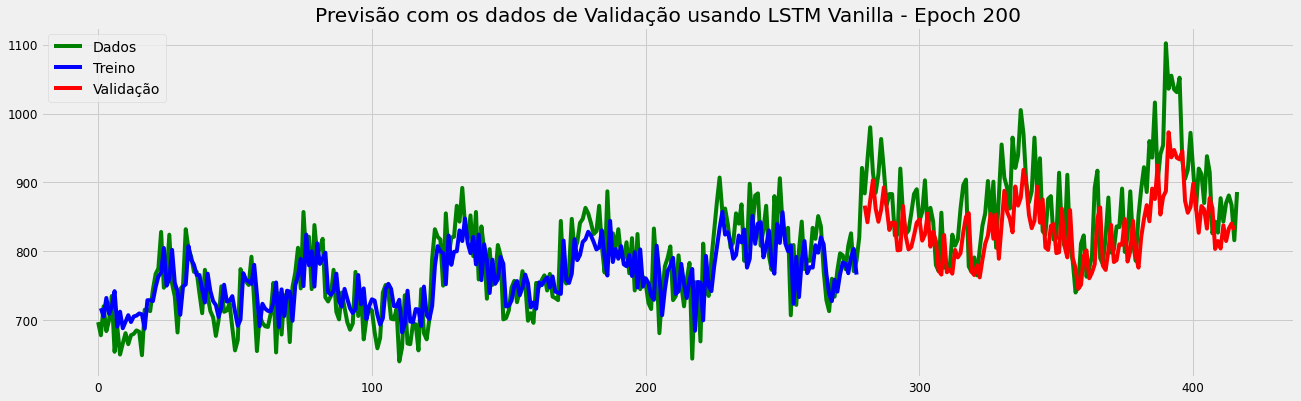

In [25]:
# Ajusta as previsões em treino para o plot
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Ajusta as previsões em validação para o plot
validPredictPlot = numpy.empty_like(dataset)
validPredictPlot[:, :] = numpy.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = validPredict

# Plot do baseline e previsões
plt.figure(figsize = (20, 6))
plt.title("Previsão com os dados de Validação usando LSTM Vanilla - Epoch 200") 
plt.plot(scaler.inverse_transform(dataset), label = 'Dados',color = 'green')
plt.plot(trainPredictPlot, label = 'Treino', color = 'blue')
plt.plot(validPredictPlot, label = 'Validação', color = 'red')
plt.legend(loc = 'upper left') 
plt.show()

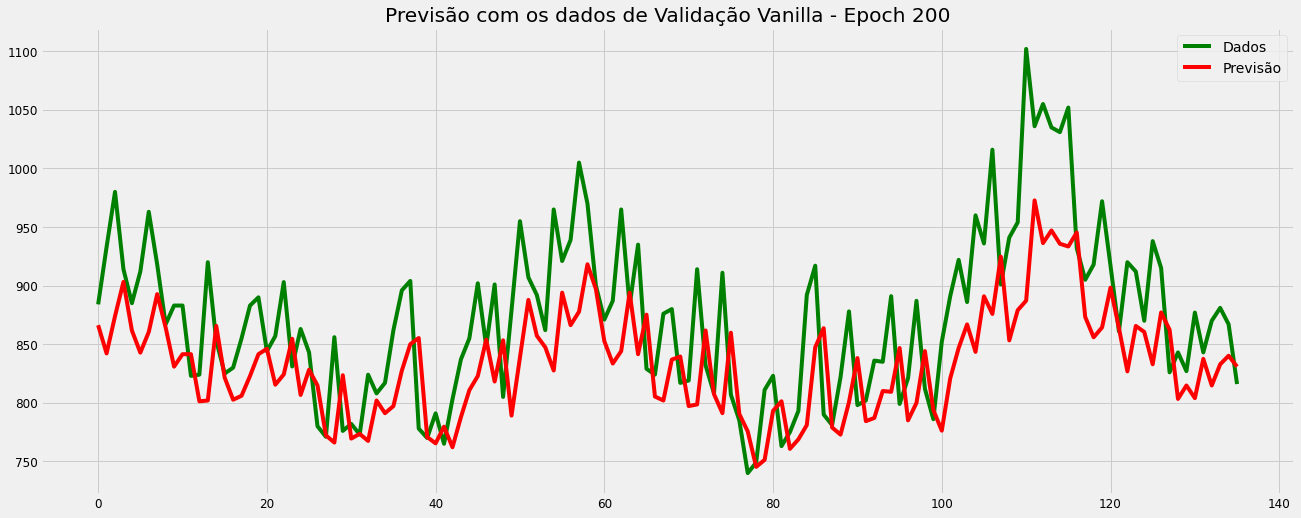

In [26]:
# Plot do baseline e previsões
plt.figure(figsize = (20, 8))
plt.title("Previsão com os dados de Validação Vanilla - Epoch 200") 
plt.plot(validY[0], label = 'Dados', color = 'green') 
plt.plot(validPredict[:,0], label = 'Previsão', color = 'red') 
plt.legend(loc = 'best') 
plt.show()

<a id='etapa5'></a>
## Etapa 5: Realizar as Previsões

## Vamos fazer o Forecasting para 24 dias de horizonte de previsão. 

In [27]:
# Carrega os dados
dataframediario = pandas.read_csv("./data/AIH.csv", usecols = [0, 1], engine = 'python')
dataframediario['Data'] = pandas.to_datetime(dataframediario.Data, format = '%d/%m/%Y')
dataframediario = dataframediario.set_index('Data')
# Reamostrando os dados para frequência semanal - Usando o valor médio do número de óbitos de pacientes – AIH
dataframesemanal = dataframediario['QT_INTER'].resample('W').sum()
dataframe = dataframesemanal.to_frame()
dataframe.drop(dataframe.head(1).index,inplace=True) # drop first 1 rows
dataframe.drop(dataframe.tail(1).index,inplace=True) # drop last 1 rows
dataframediario.reset_index(drop=True)

datasetfull = dataframe.values
datasetfull = datasetfull.astype('float32')

# Split em treino e teste
train_size = int(len(datasetfull) * 0.75)
test_size = len(datasetfull) - train_size
dataset, test = datasetfull[0:train_size,:], datasetfull[train_size:len(datasetfull),:]

# Normaliza os dados
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset)

# Normaliza os dados de Teste
scalerTeste = MinMaxScaler(feature_range = (0, 1))
testScaler = scalerTeste.fit_transform(test)

# Split em treino e validação
train_size = int(len(dataset) * 0.67)
valid_size = len(dataset) - train_size
train, valid = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape em X=t e Y=t+1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(testScaler, look_back)

# Reshape do input para: [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = numpy.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [28]:
#carrega o modelo
model = load_model(os.path.join(save_path,"RNN02_AIH_LSTM_Sem_early.h5"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Previsões com dados de Teste
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)

In [30]:
# Inverte as previsões por conta da normalização
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scalerTeste.inverse_transform(testPredict)
testY = scalerTeste.inverse_transform([testY])

In [31]:
# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.4f RMSE' % (trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('Score em Validação: %.4f RMSE' % (validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.4f RMSE' % (testScore))

Score em Treino: 45.2500 RMSE
Score em Validação: 63.4594 RMSE
Score em Teste: 61.6839 RMSE


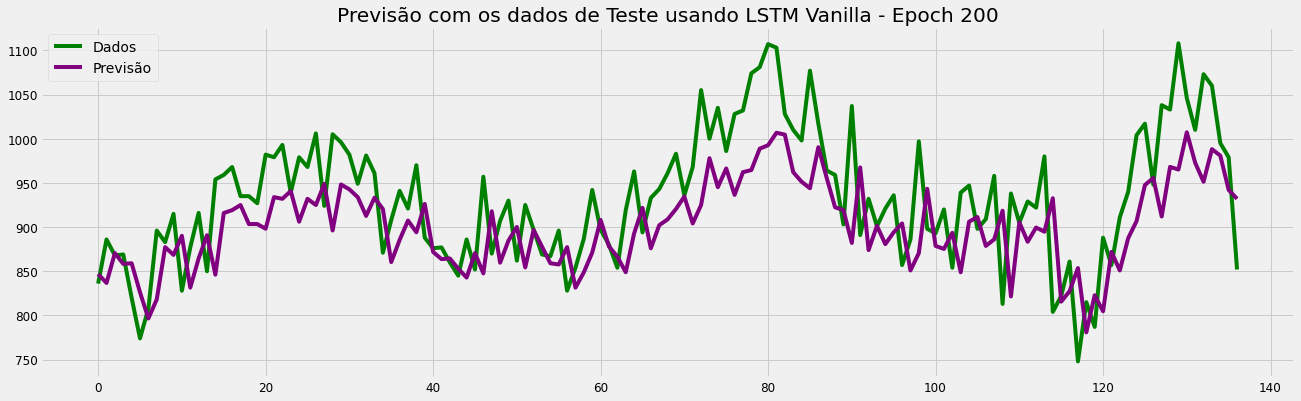

In [32]:
# Plot do baseline e previsões
plt.figure(figsize = (20, 6))
plt.title("Previsão com os dados de Teste usando LSTM Vanilla - Epoch 200") 
plt.plot(testY[0], label = 'Dados', color = 'green') 
plt.plot(testPredict[:,0], label = 'Previsão', color = 'purple') 
plt.legend(loc = 'best') 
plt.show()

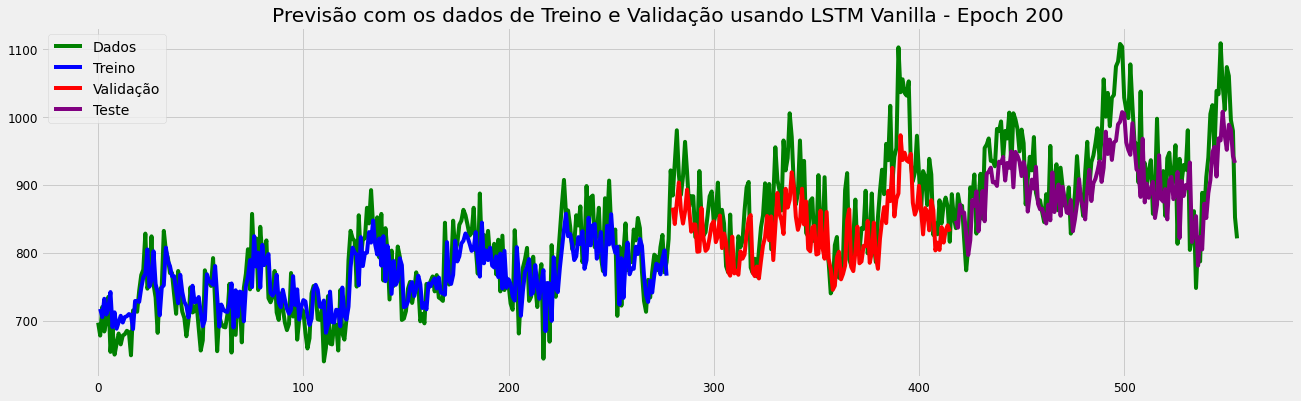

In [33]:
# Ajusta as previsões em treino para o plot
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Ajusta as previsões em validação para o plot
validPredictPlot = numpy.empty_like(dataset)
validPredictPlot[:, :] = numpy.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = validPredict

# Ajusta as previsões em validação para o plot
testPredictPlot = numpy.empty_like(datasetfull)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[(len(trainPredict) + len(validPredict))+(look_back*2)+3:len(datasetfull)-1, :] = testPredict

# Plot do baseline e previsões
plt.figure(figsize = (20, 6))
plt.title("Previsão com os dados de Treino e Validação usando LSTM Vanilla - Epoch 200") 

plt.plot(datasetfull, label = 'Dados',color = 'green')
plt.plot(trainPredictPlot, label = 'Treino', color = 'blue')
plt.plot(validPredictPlot, label = 'Validação', color = 'red')
plt.plot(testPredictPlot, label = 'Teste', color = 'purple')
plt.legend(loc = 'upper left') 
plt.show()

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade no portal da DSA: www.datascienceacademy.com.br

# Fim